# Exam Project: The formation of ISIS' Social Media Network
Group members: Zeyu Zhao, Helge Zille, Edith Zink, Sina Smid
# Sentiment Analysis and Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import networkx as nx

from our_functions import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') # makes the bar charts red on grey background with grid, I think it is nice
default_red = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jtz169\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [17]:
%run ./lad_models_22052019.ipynb

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.445044 -0.007576       1        1  15.906739
5     -0.075556  0.010924       2        1  14.774702
4     -0.064591 -0.012590       3        1  13.391531
1     -0.072313 -0.353547       4        1  13.197330
2     -0.061862  0.311270       5        1  13.183871
0     -0.057101  0.009006       6        1  11.006790
6     -0.058696  0.020417       7        1   9.317280
7     -0.054926  0.022095       8        1   9.221764, topic_info=     Category         Freq      Term        Total  loglift  logprob
143   Default  1586.000000      kill  1586.000000  30.0000  30.0000
247   Default  1053.000000      isis  1053.000000  29.0000  29.0000
125   Default   874.000000      army   874.000000  28.0000  28.0000
673   Default   749.000000      near   749.000000  27.0000  27.0000
438   Default   823.000000     force   823.000000  26.0000  26.0000
127   Default   798.000000      city   798.000000  25.0000  25.0000
139   Default   822.000000   soldier   822.000000  24.0000  24.0000
268   Default   647.000000     iraqi   647.000000  23.0000  23.0000
100   Default   605.000000   fighter   605.000000  22.0000  22.0000
63    Default   634.000000     state   634.000000  21.0000  21.0000
48    Default   622.000000   islamic   622.000000  20.0000  20.0000
149   Default   568.000000    attack   568.000000  19.0000  19.0000
73    Default   431.000000       abu   431.000000  18.0000  18.0000
240   Default   506.000000     assad   506.000000  17.0000  17.0000
196   Default   548.000000      area   548.000000  16.0000  16.0000
345   Default   476.000000     allah   476.000000  15.0000  15.0000
227   Default   397.000000   capture   397.000000  14.0000  14.0000
246   Default   474.000000   destroy   474.000000  13.0000  13.0000
152   Default   463.000000     today   463.000000  12.0000  12.0000
37    Default   416.000000    report   416.000000  11.0000  11.0000
38    Default   408.000000    syrian   408.000000  10.0000  10.0000
14    Default   328.000000       one   328.000000   9.0000   9.0000
91    Default   390.000000       say   390.000000   8.0000   8.0000
184   Default   320.000000      like   320.000000   7.0000   7.0000
121   Default   414.000000     north   414.000000   6.0000   6.0000
261   Default   298.000000    target   298.000000   5.0000   5.0000
64    Default   347.000000      take   347.000000   4.0000   4.0000
111   Default   343.000000   village   343.000000   3.0000   3.0000
274   Default   377.000000    regime   377.000000   2.0000   2.0000
641   Default   341.000000      tank   341.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
73     Topic8   430.286682       abu   431.135132   2.3816  -2.9984
14     Topic8   328.135834       one   328.983917   2.3810  -3.2694
184    Topic8   319.350922      like   320.199249   2.3810  -3.2966
209    Topic8   235.610977       see   236.459167   2.3800  -3.6007
66     Topic8   202.290512      back   203.138779   2.3794  -3.7532
182    Topic8   179.791824      help   180.639999   2.3789  -3.8711
226    Topic8   159.001877       war   159.849899   2.3783  -3.9939
552    Topic8   148.679916      call   149.528000   2.3779  -4.0611
852    Topic8   139.487228      join   140.335831   2.3775  -4.1249
375    Topic8   134.120285     think   134.968475   2.3773  -4.1641
374    Topic8   124.819695     since   125.668182   2.3768  -4.2360
589    Topic8   124.038712       guy   124.887657   2.3768  -4.2423
12     Topic8   112.811340   account   113.659752   2.3761  -4.3371
976    Topic8   111.802734    accord   112.651245   2.3760  -4.3461
28     Topic8    90.353012       let    91.201317   2.3743  -4.5591
74     Topic8    89.424866    accept    90.273071   2.3742  -4.5695
758    Topic8    84.576958     ready    85.426605   2.3736  -4.6252
1487   Topic8    84.186966      fuck    85.036644   2.3736  -4.6298
459    Topic8    

In [18]:
def topics_sentences(ldamodel, corpus):
    df = pd.DataFrame(columns=['0', '1', '2','3','4','5','6','7'])
    model= ldamodel[corpus]
    for line in range(len(model)):
        temp_list =[]
        for (topic, perc) in model[line][0]:
            temp_list=temp_list+[perc]
        #some tweets have value for than 20 topics
        if len(temp_list)<8:
            temp_list =[0]*8
            for (topic, perc) in model[line][0]:
                temp_list[topic]=perc
                
        s = pd.Series(temp_list, index = df.columns)
        df = df.append(s,ignore_index =True)
    return df
            
    

In [19]:
model = lda_model[corpus]
tl=[]
for (topic, perc) in  model[1][0]:
    tl=tl+[perc]

new_df = topics_sentences(lda_model,corpus)
new_df = new_df.reset_index()
perc_df = pd.concat([df, new_df], axis=1)

In [20]:
perc_df

,index,name,username,description,location,followers,numberstatuses,time,tweets,date,...,topic,index,0,1,2,3,4,5,6,7
0,3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:37:00,"SHEIKH NASIR AL WUHAYSHI (HA), LEADER OF AQAP...",2015-01-06,...,4,0,0.081753,0.273982,0.097621,0.117426,0.097185,0.108380,0.156961,0.066692
1,4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:45:00,AQAP: 'RESPONSE TO SHEIKH BAGHDADIS STATEMENT...,2015-01-06,...,5,1,0.085526,0.102056,0.102127,0.168989,0.101671,0.113382,0.256478,0.069771
2,6,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:04:00,OH MURABIT! :,2015-01-06,...,0,2,0.111175,0.132662,0.132754,0.159686,0.132161,0.147385,0.093484,0.090693
3,7,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:06:00,'A COLLECTION OF THE WORDS OF THE U'LAMA REGA...,2015-01-06,...,4,3,0.094220,0.112431,0.112509,0.287836,0.112006,0.124908,0.079228,0.076863
4,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:17:00,Aslm Please share our new account after the pr...,2015-01-06,...,4,4,0.162782,0.135679,0.093499,0.154705,0.093081,0.103803,0.108083,0.148369
5,9,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-10 00:05:00,AQAP STATEMENT REGARDING THE BLESSED RAID IN ...,2015-01-10,...,9,5,0.081753,0.097554,0.097622,0.337961,0.097185,0.108380,0.112853,0.066692
6,12,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-22 20:14:00,,2015-01-22,...,0,6,0.111175,0.132662,0.132754,0.159686,0.132161,0.147385,0.093484,0.090693
7,14,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-09 10:54:00,Not translating it either.,2015-02-09,...,4,7,0.099267,0.118452,0.118535,0.142582,0.118005,0.131598,0.083471,0.188090
8,15,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-12 13:03:00,"Aslm, anybody translating the new JN video? Wi...",2015-02-12,...,4,8,0.078665,0.179711,0.093524,0.112705,0.137277,0.107820,0.066453,0.223845
9,16,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-12 13:11:00,So we will translate it then inshallah let...,2015-02-12,...,4,9,0.094773,0.113691,0.112549,0.135696,0.113889,0.131044,0.080155,0.218204


In [21]:
####################################################################################################
####################################################################################################
################These are additional codes for identifying dominant topics##############################
#######################################################################################################
####################################################################################################



def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)            
            else:
                break   
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2740,"force, report, syrian, take, tank, people, con...","[sheikh, nasir, leader, aqap, promise, victory]"
1,1,6.0,0.2565,"near, target, west, explosion, shiite, command...","[aqap, response, sheikh, statement, disbeliever]"
2,2,3.0,0.1597,"kill, soldier, attack, area, destroy, today, n...",[]
3,3,3.0,0.2878,"kill, soldier, attack, area, destroy, today, n...","[words, regard, dawlah]"
4,4,0.0,0.1628,"army, iraqi, fighter, capture, huge, pig, rama...","[please, share, new, account, previous, one, s..."
5,5,3.0,0.3380,"kill, soldier, attack, area, destroy, today, n...","[aqap, statement, regard, bless, raid, france]"
6,6,3.0,0.1597,"kill, soldier, attack, area, destroy, today, n...",[]
7,7,7.0,0.1881,"abu, one, like, see, back, help, war, call, jo...","[translate, either]"
8,8,7.0,0.2238,"abu, one, like, see, back, help, war, call, jo...","[anybody, translate, new, video, translate, no..."
9,9,7.0,0.2182,"abu, one, like, see, back, help, war, call, jo...","[translate, let, anybody]"


In [158]:
final_df=perc_df.groupby('username').mean().reset_index()[['username','followers','polarity','0','1', '2','3','4','5','6','7']]
nodes_name = list(final_df['username'])

G_final=nx.Graph()
G_final.add_nodes_from(nodes_name)

edge_list=[]
for i in range(len(nodes_name)):
    for j in range(len(nodes_name)):
        w=0
        for k in range(8):
            w=w+(final_df.iloc[i][str(k)]-final_df.iloc[j][str(k)])**2
        edge_list = edge_list + [(final_df.iloc[i]['username'],final_df.iloc[j]['username'],w)]
        
w = []
for i in range(len(edge_list)):
    x= [w for (a,b,w) in edge_list]
x= np.array(x)
print(min(x),np.percentile(x,10),np.percentile(x,25),np.percentile(x,50),np.percentile(x,75),np.percentile(x,90),max(x))

threshold_1=np.percentile(x,3)
threshold_2=np.percentile(x,6)
threshold_3=np.percentile(x,9)

0.0 0.00044299996429610143 0.0007970005915476886 0.0015937974635835532 0.0035448934161618926 0.00667337076854772 0.04321396549416895


In [159]:
strong_edges = []
weak_edges = []
weakest_edges=[]
for (a,b,w) in edge_list:
    if w < threshold_1:
        strong_edges= strong_edges + [(a,b)]
        
for (a,b,w) in edge_list:
    if ( w > threshold_1 and w < threshold_2):
        weak_edges= weak_edges + [(a,b)]     
        
for (a,b,w) in edge_list:
    if ( w > threshold_2 and w < threshold_3):
        weakest_edges= weakest_edges + [(a,b)]  
        
G_final.add_edges_from (strong_edges)
G_final.add_edges_from (weak_edges)
G_final.add_edges_from (weakest_edges)



In [167]:
ave_po = list(final_df['polarity']*1000+110)
follower_n=list(final_df['followers'])
tweets_n =[]
for i in range(len(list(G_final.nodes))):
    tweets_n =  tweets_n + [sum(list(user_topic_count.loc[list(G_final.nodes)[i]].iloc[:,0]))*10]

# set the size for accounts with follower numbers smaller than 50
for i in range(len(follower_n)):
    if follower_n[i] < 50:
        follower_n[i] = 50 
        
pos= nx.spring_layout(G_final,k=12/math.sqrt(G_final.order()))

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


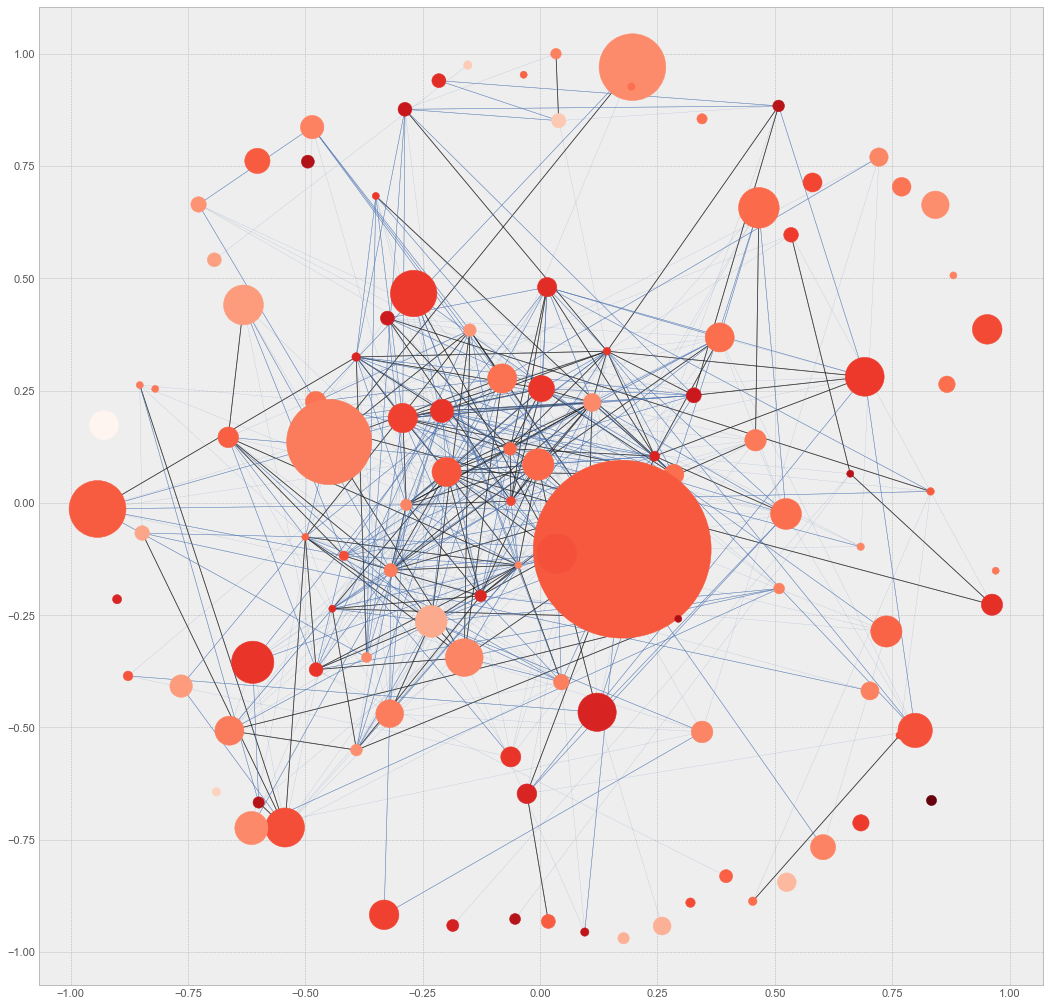

In [170]:
import math
plt.figure(figsize=(18,18))

nx.draw_networkx_nodes(G_final,pos, with_labels=True, node_color=ave_po, cmap=plt.cm.Reds, node_size=follower_n)
nx.draw_networkx_edges(G_final, pos , edgelist=strong_edges,
                       width=0.75, alpha = 0.6)
nx.draw_networkx_edges(G_final, pos , edgelist=weak_edges,
                       width=0.5,alpha=0.6, edge_color='b')
nx.draw_networkx_edges(G_final, pos , edgelist=weakest_edges,
                       width=0.25,alpha=0.3, edge_color='b', style='dashed')
#nx.draw_networkx_labels(G_final, pos, font_size=10, font_family='sans-serif')
plt.show()

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


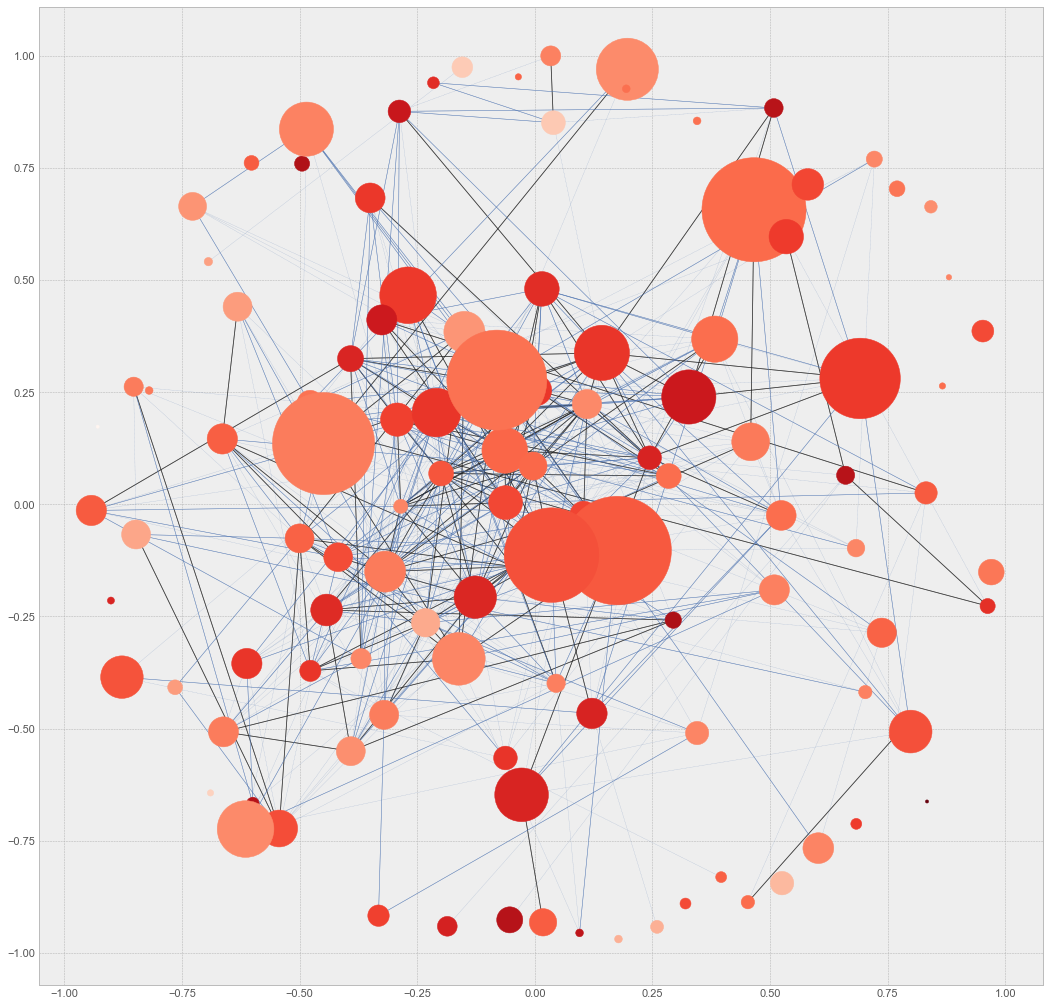

In [169]:
import math
plt.figure(figsize=(18,18))

nx.draw_networkx_nodes(G_final,pos, with_labels=True, node_color=ave_po, cmap=plt.cm.Reds, node_size=tweets_n)
nx.draw_networkx_edges(G_final, pos , edgelist=strong_edges,
                       width=0.75, alpha = 0.6)
nx.draw_networkx_edges(G_final, pos , edgelist=weak_edges,
                       width=0.5,alpha=0.6, edge_color='b')
nx.draw_networkx_edges(G_final, pos , edgelist=weakest_edges,
                       width=0.25,alpha=0.3, edge_color='b', style='dashed')
#nx.draw_networkx_labels(G_final, pos, font_size=10, font_family='sans-serif')
plt.show()

In [141]:
dominant_df = pd.concat([perc_df, df_dominant_topic], axis=1)

topic_count = dominant_df.groupby('Dominant_Topic').count()['index']

user_topic_count = dominant_df.groupby(['username','Dominant_Topic']).count()['index']

follower_df = perc_df.groupby('username').mean()['followers']

print("those are accounts with fewest followers:")
for i in range(len(follower_df)):
    if follower_df[i] < 30:
        print(follower_df.index[i])
        print(user_topic_count.loc[follower_df.index[i]])
print()
print("those are accounts with most followers:")
for i in range(len(follower_df)):
    if follower_df[i] >2000:
        print(follower_df.index[i])
        print(user_topic_count.loc[follower_df.index[i]])

those are accounts with fewest followers:
Abdul__05
                index  index
Dominant_Topic              
3.0                 2      2
BaqiyaIs
                index  index
Dominant_Topic              
0.0                 6      6
1.0                 5      5
2.0                11     11
3.0                25     25
4.0                11     11
5.0                 4      4
6.0                 2      2
7.0                 2      2
Mosul_05
                index  index
Dominant_Topic              
0.0                 1      1
2.0                 2      2
4.0                 2      2
5.0                 1      1
abdlrhmn15
                index  index
Dominant_Topic              
0.0                 2      2
1.0                10     10
2.0                13     13
3.0                18     18
4.0                 9      9
5.0                26     26
6.0                 6      6
7.0                 5      5
al_zaishan10
                index  index
Dominant_Topic              
0.0    

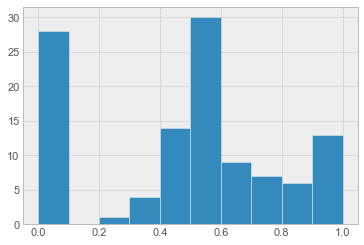

Those are accounts with an coefficient value 1:
1Dawlah_III
AbuLaythAlHindi
Abu_Ibn_Taha
JohnsonsBot
JoinISNation102
ManKhalfahum
Nidalgazaui
QassamiMarwan
abuayisha108
ks48a174031
mustaklash
sonofshishan
Average followers of this gourp is 778.3474597006333
Average number of tweets is 63.666666666666664

Those are accounts with an coefficient value 0:
04_8_1437
432Mryam
ALK___226
Afriqqiya_252
BaqiyaIs
DabiqsweetsMan
Dieinurage308
GunsandCoffee70
MaghrebiQ
Mosul_05
WhiteCat_7
YazeedDhardaa25
___KU217_y
````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
abuayisha102
abubakerdimshqi
abutariq040
al_nusra
almuhajirun9
ansarakhilafa
baaqiya_01
bintraveller
dieinurage29__7
emran_getu
fahadslay614
kIakishini5
newerajihadi61
wayff44rer
Average 

In [155]:
x=list(nx.clustering(G_final).values())
plt.hist(x)
###plt.xscale('log') 
plt.show()

mean_follower_1 = 0
mean_follower_0 = 0
total_tweets_1 = 0
total_tweets_0 = 0
count = 0
print('Those are accounts with an coefficient value 1:')
for i in range(len(list(G_final.nodes))):
    if x[i] == 1:
        count = count +1
        print (list(G_final.nodes)[i])
        mean_follower_1 = mean_follower_1 + follower_df[list(G_final.nodes)[i]]
        total_tweets_1 = total_tweets_1 + sum(list(user_topic_count.loc[list(G_final.nodes)[i]].iloc[:,0]))
        
print('Average followers of this gourp is', mean_follower_1/count)
print('Average number of tweets is', total_tweets_1/count )
print()

count = 0
print('Those are accounts with an coefficient value 0:')
for i in range(len(list(G_final.nodes))):
    if x[i] == 0:
        count = count + 1
        print (list(G_final.nodes)[i])
        mean_follower_0 = mean_follower_0 + follower_df[list(G_final.nodes)[i]]
        total_tweets_0 = total_tweets_0 + sum(list(user_topic_count.loc[list(G_final.nodes)[i]].iloc[:,0]))
        
print('Average followers of this gourp is', mean_follower_0/count)
print('Average number of tweets is', total_tweets_0/count )
print()


###
Now we are diving them into three periods
###

In [153]:
perc_df

,index,name,username,description,location,followers,numberstatuses,time,tweets,date,...,topic,index,0,1,2,3,4,5,6,7
0,3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:37:00,"SHEIKH NASIR AL WUHAYSHI (HA), LEADER OF AQAP...",2015-01-06,...,4,0,0.081753,0.273982,0.097621,0.117426,0.097185,0.108380,0.156961,0.066692
1,4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:45:00,AQAP: 'RESPONSE TO SHEIKH BAGHDADIS STATEMENT...,2015-01-06,...,5,1,0.085526,0.102056,0.102127,0.168989,0.101671,0.113382,0.256478,0.069771
2,6,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:04:00,OH MURABIT! :,2015-01-06,...,0,2,0.111175,0.132662,0.132754,0.159686,0.132161,0.147385,0.093484,0.090693
3,7,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:06:00,'A COLLECTION OF THE WORDS OF THE U'LAMA REGA...,2015-01-06,...,4,3,0.094220,0.112431,0.112509,0.287836,0.112006,0.124908,0.079228,0.076863
4,8,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 22:17:00,Aslm Please share our new account after the pr...,2015-01-06,...,4,4,0.162782,0.135679,0.093499,0.154705,0.093081,0.103803,0.108083,0.148369
5,9,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-10 00:05:00,AQAP STATEMENT REGARDING THE BLESSED RAID IN ...,2015-01-10,...,9,5,0.081753,0.097554,0.097622,0.337961,0.097185,0.108380,0.112853,0.066692
6,12,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-22 20:14:00,,2015-01-22,...,0,6,0.111175,0.132662,0.132754,0.159686,0.132161,0.147385,0.093484,0.090693
7,14,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-09 10:54:00,Not translating it either.,2015-02-09,...,4,7,0.099267,0.118452,0.118535,0.142582,0.118005,0.131598,0.083471,0.188090
8,15,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-12 13:03:00,"Aslm, anybody translating the new JN video? Wi...",2015-02-12,...,4,8,0.078665,0.179711,0.093524,0.112705,0.137277,0.107820,0.066453,0.223845
9,16,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-02-12 13:11:00,So we will translate it then inshallah let...,2015-02-12,...,4,9,0.094773,0.113691,0.112549,0.135696,0.113889,0.131044,0.080155,0.218204


In [171]:
df_1 =perc_df[perc_df['time'] < pd.Timestamp(year=2016, month=1, day=31, hour=12)]
df_2 =perc_df[(perc_df.time < pd.Timestamp(year=2016, month=2, day=26, hour=12)) & (perc_df.time > pd.Timestamp(year=2016, month=1, day=31, hour=12))]
df_3 =perc_df[perc_df['time'] > pd.Timestamp(year=2016, month=2, day=26, hour=12)]

In [172]:
final_df_1=df_1.groupby('username').mean().reset_index()[['username','followers','polarity','0','1', '2','3','4','5','6','7']]
nodes_name_1 = list(final_df_1['username'])

G_final_1=nx.Graph()
G_final_1.add_nodes_from(nodes_name_1)

edge_list_1=[]
for i in range(len(nodes_name_1)):
    for j in range(len(nodes_name_1)):
        w=0
        for k in range(8):
            w=w+(final_df_1.iloc[i][str(k)]-final_df_1.iloc[j][str(k)])**2
        edge_list_1 = edge_list_1 + [(final_df_1.iloc[i]['username'],final_df_1.iloc[j]['username'],w)]



In [173]:
w = []
for i in range(len(edge_list_1)):
    x= [w for (a,b,w) in edge_list_1]
x= np.array(x)
print(min(x),np.percentile(x,10),np.percentile(x,25),np.percentile(x,50),np.percentile(x,75),np.percentile(x,90),max(x))

threshold_1=np.percentile(x,5)
threshold_2=np.percentile(x,10)
threshold_3=np.percentile(x,20)

0.0 0.0007859949868032402 0.0014285638023610605 0.0028347544203085615 0.006265996225342218 0.012774459691369807 0.05697831914841056


In [174]:
strong_edges = []
weak_edges = []
weakest_edges=[]
for (a,b,w) in edge_list_1:
    if w < threshold_1:
        strong_edges= strong_edges + [(a,b)]
        
for (a,b,w) in edge_list_1:
    if ( w > threshold_1 and w < threshold_2):
        weak_edges= weak_edges + [(a,b)]     
        
for (a,b,w) in edge_list_1:
    if ( w > threshold_2 and w < threshold_3):
        weakest_edges= weakest_edges + [(a,b)]  
        
G_final_1.add_edges_from (strong_edges)
G_final_1.add_edges_from (weak_edges)
G_final_1.add_edges_from (weakest_edges)

ave_po = list(final_df_1['polarity']*1000+110)
follower_n=list(final_df_1['followers'])

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


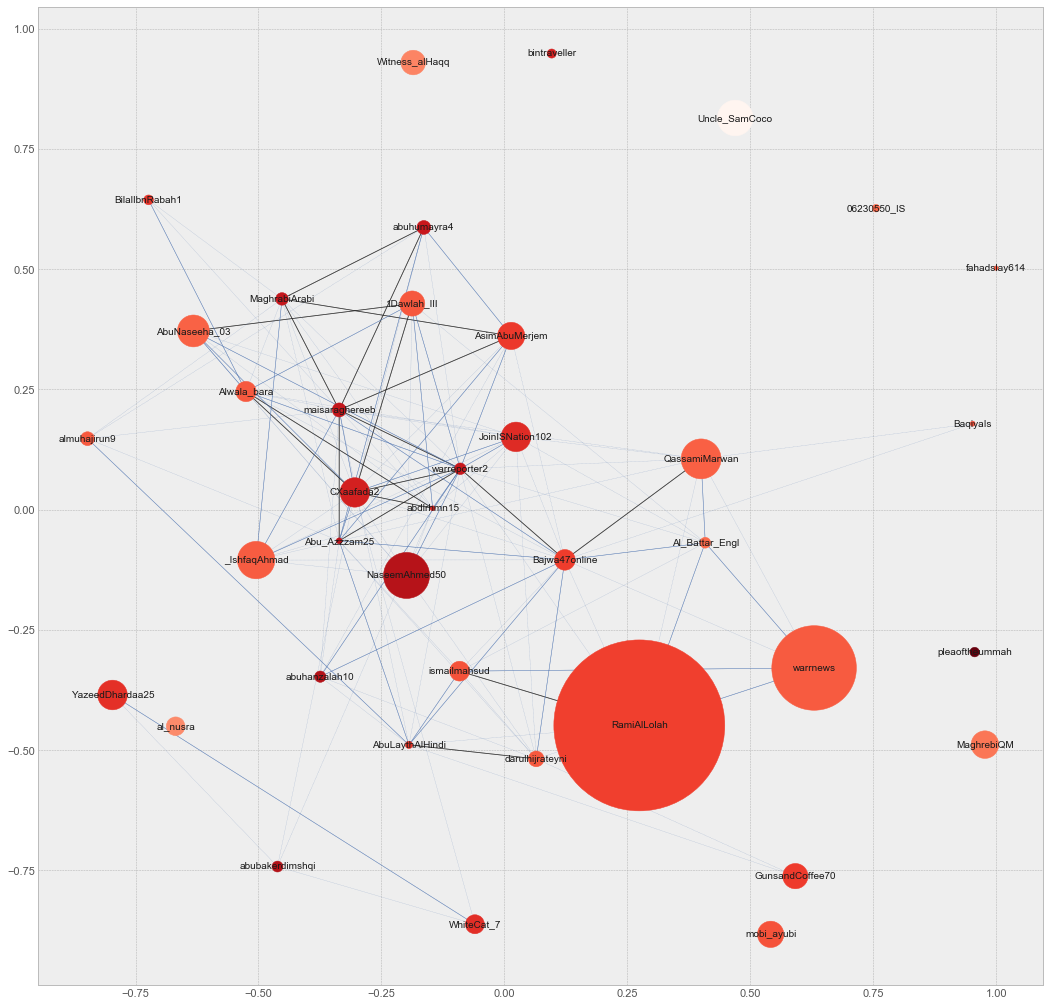

In [175]:
plt.figure(figsize=(18,18))
pos= nx.spring_layout(G_final_1,k=12/math.sqrt(G_final.order()))
nx.draw_networkx_nodes(G_final_1,pos, with_labels=True, node_color=ave_po, cmap=plt.cm.Reds, node_size=follower_n)
nx.draw_networkx_edges(G_final_1, pos , edgelist=strong_edges,
                       width=0.75, alpha = 0.6)
nx.draw_networkx_edges(G_final_1, pos , edgelist=weak_edges,
                       width=0.5,alpha=0.6, edge_color='b')
nx.draw_networkx_edges(G_final_1, pos , edgelist=weakest_edges,
                       width=0.25,alpha=0.3, edge_color='b', style='dashed')
nx.draw_networkx_labels(G_final_1, pos, font_size=10, font_family='sans-serif')
plt.show()

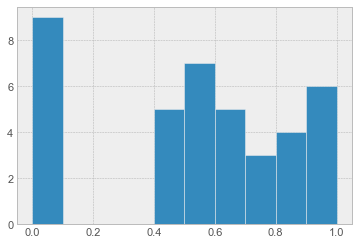

Those are accounts with an coefficient value 1:
BaqiyaIs
BilalIbnRabah1
GunsandCoffee70
YazeedDhardaa25


In [176]:
x=list(nx.clustering(G_final_1).values())
plt.hist(x)
#plt.xscale('log') 
plt.show()

print('Those are accounts with an coefficient value 1:')
for i in range(len(list(G_final_1.nodes))):
    if x[i] == 1:
        print (list(G_final_1.nodes)[i])

In [177]:
final_df_2=df_2.groupby('username').mean().reset_index()[['username','followers','polarity','0','1', '2','3','4','5','6','7']]
nodes_name_2 = list(final_df_2['username'])

G_final_2=nx.Graph()
G_final_2.add_nodes_from(nodes_name_2)

edge_list_2=[]
for i in range(len(nodes_name_2)):
    for j in range(len(nodes_name_2)):
        w=0
        for k in range(8):
            w=w+(final_df_2.iloc[i][str(k)]-final_df_2.iloc[j][str(k)])**2
        edge_list_2 = edge_list_2 + [(final_df_2.iloc[i]['username'],final_df_2.iloc[j]['username'],w)]


In [178]:
w = []
for i in range(len(edge_list_2)):
    x= [w for (a,b,w) in edge_list_2]
x= np.array(x)
print(min(x),np.percentile(x,10),np.percentile(x,25),np.percentile(x,50),np.percentile(x,75),np.percentile(x,90),max(x))

threshold_1=np.percentile(x,5)
threshold_2=np.percentile(x,10)
threshold_3=np.percentile(x,20)


0.0 0.0005305552069181175 0.0011267135852297099 0.002132623309220167 0.003388424372878616 0.004798406296572947 0.02102584999287416


In [179]:
strong_edges = []
weak_edges = []
weakest_edges=[]
for (a,b,w) in edge_list_2:
    if w < threshold_1:
        strong_edges= strong_edges + [(a,b)]
        
for (a,b,w) in edge_list_2:
    if ( w > threshold_1 and w < threshold_2):
        weak_edges= weak_edges + [(a,b)]     
        
for (a,b,w) in edge_list_2:
    if ( w > threshold_2 and w < threshold_3):
        weakest_edges= weakest_edges + [(a,b)]  
        
G_final_2.add_edges_from (strong_edges)
G_final_2.add_edges_from (weak_edges)
G_final_2.add_edges_from (weakest_edges)

ave_po = list(final_df_2['polarity']*1000+110)
follower_n=list(final_df_2['followers'])

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


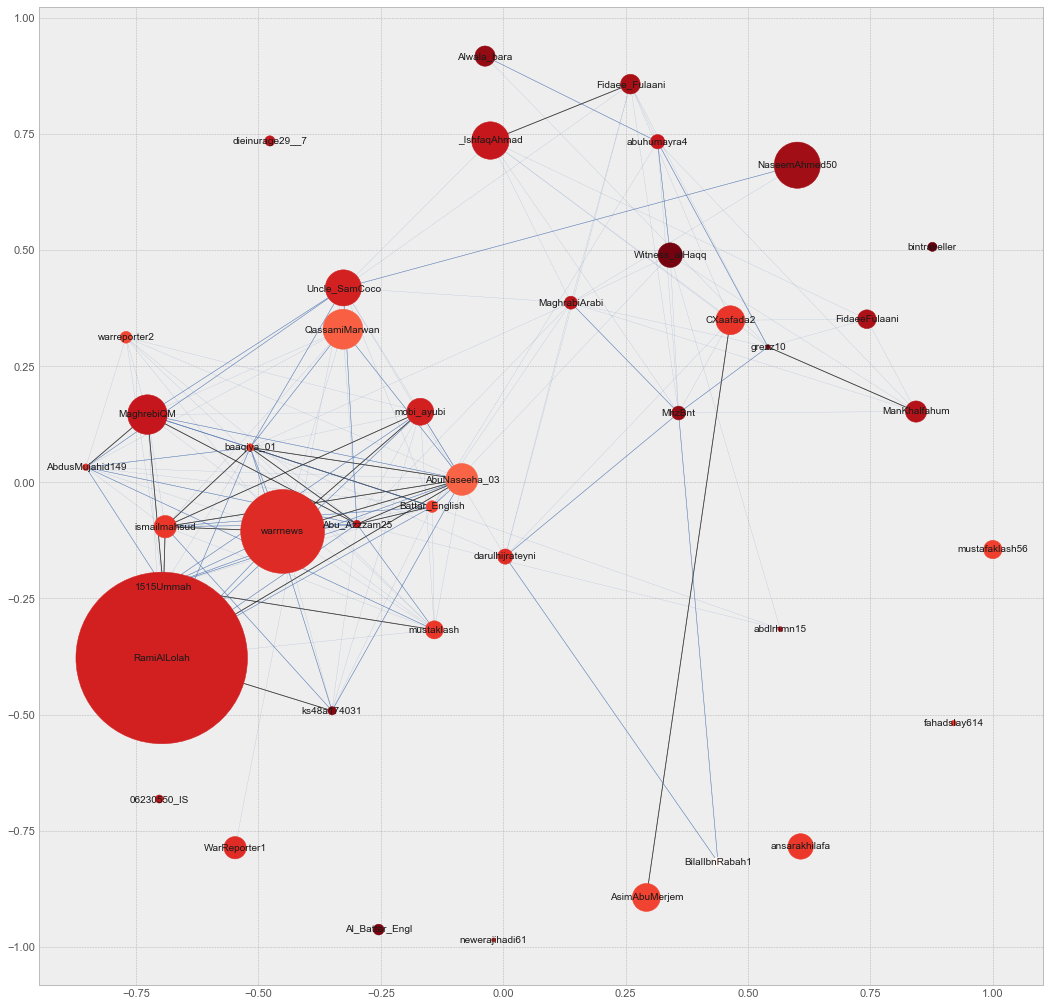

In [180]:
plt.figure(figsize=(18,18))
pos= nx.spring_layout(G_final_2, k=14/math.sqrt(G_final.order()))
nx.draw_networkx_nodes(G_final_2,pos, with_labels=True, node_color=ave_po, cmap=plt.cm.Reds, node_size=follower_n)
nx.draw_networkx_edges(G_final_2, pos , edgelist=strong_edges,
                       width=0.75, alpha = 0.6)
nx.draw_networkx_edges(G_final_2, pos , edgelist=weak_edges,
                       width=0.5,alpha=0.6, edge_color='b')
nx.draw_networkx_edges(G_final_2, pos , edgelist=weakest_edges,
                       width=0.25,alpha=0.3, edge_color='b', style='dashed')
nx.draw_networkx_labels(G_final_2, pos, font_size=10, font_family='sans-serif')
plt.show()

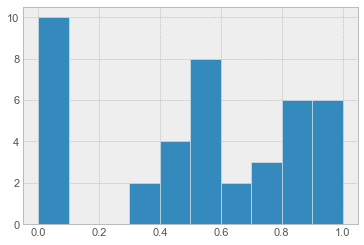

Those are accounts with an coefficient value 1:
Alwala_bara
BilalIbnRabah1
NaseemAhmed50


In [181]:
x=list(nx.clustering(G_final_2).values())
plt.hist(x)
###plt.xscale('log') 
plt.show()

print('Those are accounts with an coefficient value 1:')
for i in range(len(list(G_final_2.nodes))):
    if x[i] == 1:
        print (list(G_final_2.nodes)[i])

In [182]:
final_df_3=df_3.groupby('username').mean().reset_index()[['username','followers','polarity','0','1', '2','3','4','5','6','7']]
nodes_name_3 = list(final_df_3['username'])

G_final_3=nx.Graph()
G_final_3.add_nodes_from(nodes_name_3)

edge_list_3=[]
for i in range(len(nodes_name_3)):
    for j in range(len(nodes_name_3)):
        w=0
        for k in range(8):
            w=w+(final_df_3.iloc[i][str(k)]-final_df_3.iloc[j][str(k)])**2
        edge_list_3 = edge_list_3 + [(final_df_3.iloc[i]['username'],final_df_3.iloc[j]['username'],w)]



In [183]:
w = []
for i in range(len(edge_list_3)):
    x= [w for (a,b,w) in edge_list_3]
x= np.array(x)
print(min(x),np.percentile(x,10),np.percentile(x,25),np.percentile(x,50),np.percentile(x,75),np.percentile(x,90),max(x))

threshold_1=np.percentile(x,5)
threshold_2=np.percentile(x,10)
threshold_3=np.percentile(x,20)


0.0 0.0004007539111019046 0.0008354211734394449 0.0018806975660345094 0.005234613082585863 0.012221925807150029 0.06266718574612645


In [184]:
strong_edges = []
weak_edges = []
weakest_edges=[]
for (a,b,w) in edge_list_3:
    if w < threshold_1:
        strong_edges= strong_edges + [(a,b)]
        
for (a,b,w) in edge_list_3:
    if ( w > threshold_1 and w < threshold_2):
        weak_edges= weak_edges + [(a,b)]     
        
for (a,b,w) in edge_list_3:
    if ( w > threshold_2 and w < threshold_3):
        weakest_edges= weakest_edges + [(a,b)]  
        
G_final_3.add_edges_from (strong_edges)
G_final_3.add_edges_from (weak_edges)
G_final_3.add_edges_from (weakest_edges)

ave_po = list(final_df_3['polarity']*1000+110)
follower_n=list(final_df_3['followers'])

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


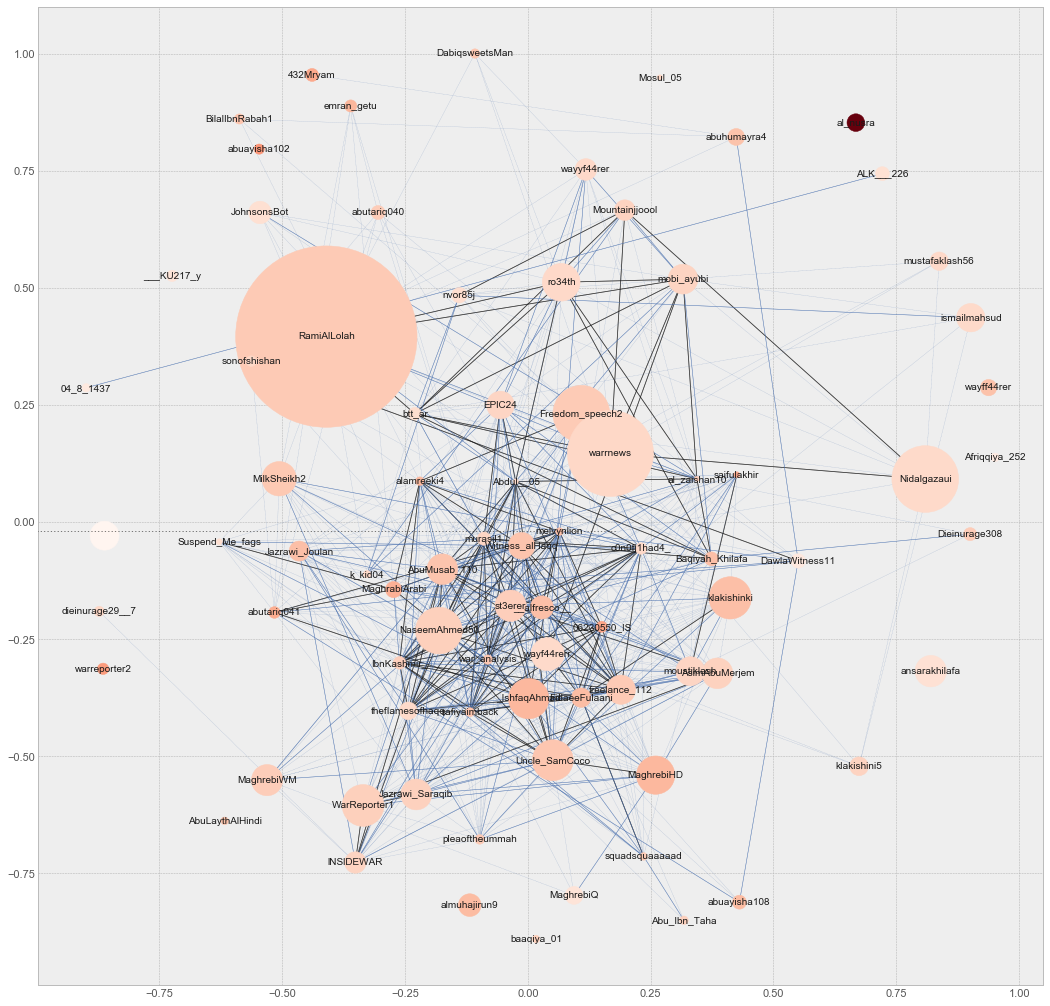

In [185]:
plt.figure(figsize=(18,18))
pos= nx.spring_layout(G_final_3, k=14/math.sqrt(G_final.order()))
nx.draw_networkx_nodes(G_final_3,pos, with_labels=True, node_color=ave_po, cmap=plt.cm.Reds, node_size=follower_n)
nx.draw_networkx_edges(G_final_3, pos , edgelist=strong_edges,
                       width=0.75, alpha = 0.6)
nx.draw_networkx_edges(G_final_3, pos , edgelist=weak_edges,
                       width=0.5,alpha=0.6, edge_color='b')
nx.draw_networkx_edges(G_final_3, pos , edgelist=weakest_edges,
                       width=0.25,alpha=0.3, edge_color='b', style='dashed')
nx.draw_networkx_labels(G_final_3, pos, font_size=10, font_family='sans-serif')
plt.show()

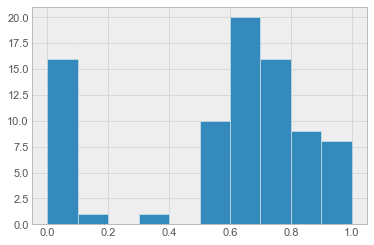

Those are accounts with an coefficient value 1:
Abu_Ibn_Taha
Dieinurage308
mustafaklash56


In [186]:
x=list(nx.clustering(G_final_3).values())
plt.hist(x)
###plt.xscale('log') 
plt.show()

print('Those are accounts with an coefficient value 1:')
for i in range(len(list(G_final_3.nodes))):
    if x[i] == 1:
        print (list(G_final_3.nodes)[i])